# 09 — RTM Phase 1b: Decision stability report (top-k membership probability)

This notebook produces **decision-level stability diagnostics** from a fitted damage model:
- posterior predictive mean damage probability `p_mean`
- posterior predictive uncertainty `p_sd`
- **top-k membership probability** `topk_prob(k)` = P(building ∈ top-k by predicted risk)

Key outputs:
- `outputs/rtm/decision_stability/v1b/decision_metrics_v1b.csv`
- plots saved to `outputs/rtm/decision_stability/v1b/figures/`

Notes:
- `mean(topk_prob)` is **forced** to equal `k/N` (sanity theorem), so we focus on *non-trivial* metrics:
  - share with `topk_prob > τ`
  - share with `topk_prob ∈ (τ_low, τ_high)` (borderline set)
  - entropy of membership probability
  - overlap / stability between deterministic ranking and posterior membership

In [1]:
from __future__ import annotations

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import xarray as xr
import arviz as az
import matplotlib.pyplot as plt

# --- Repo root + import path fix (so `import src...` works) ---
REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name == "notebooks":
    REPO_ROOT = REPO_ROOT.parent

sys.path.insert(0, str(REPO_ROOT))  # <- critical

print("Repo root:", REPO_ROOT)
print("Has src  :", (REPO_ROOT / "src").exists())
print("sys.path[0]:", sys.path[0])

# --- Outputs ---
OUT_DIR = REPO_ROOT / "outputs" / "rtm" / "decision_stability" / "v1b"
FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- Inputs ---
IDATA_PATH = REPO_ROOT / "outputs" / "rtm" / "inference" / "rtm_damage_v1b_logistic_idata.nc"
E_PATH     = REPO_ROOT / "outputs" / "rtm" / "water_exposure_Ehat_v0.parquet"

print("OUT  :", OUT_DIR)
print("IDATA:", IDATA_PATH)
print("E    :", E_PATH)

assert (REPO_ROOT / "src").exists(), f"Can't find src/ at repo root: {REPO_ROOT}"
assert E_PATH.exists(), f"Missing exposure parquet: {E_PATH}"
assert IDATA_PATH.exists(), f"Missing idata: {IDATA_PATH}"

Repo root: C:\Users\C.Price\Habnetic\resilient-housing-bayes
Has src  : True
sys.path[0]: C:\Users\C.Price\Habnetic\resilient-housing-bayes
OUT  : C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b
IDATA: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\inference\rtm_damage_v1b_logistic_idata.nc
E    : C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\water_exposure_Ehat_v0.parquet


## Load data (E_hat, hazard) and posterior predictive summaries

We need per-building:
- `E_hat`
- `H_pluvial_v1_mm`
- posterior predictive `p_mean`, `p_sd` (from inference)

Then we can compute decision quantities:
- `topk_prob(k)` for multiple k
- entropy / borderline share metrics

In [2]:
from src.rtm.io_hazard import load_rtm_pluvial_v1_buildings

E_df = pd.read_parquet(E_PATH)[["bldg_id", "E_hat"]]
H_df = load_rtm_pluvial_v1_buildings()[["bldg_id", "H_pluvial_v1_mm"]]

df = E_df.merge(H_df, on="bldg_id", validate="one_to_one")
print("Rows (E+H):", len(df))
df.head()

Rows (E+H): 221324


,bldg_id,E_hat,H_pluvial_v1_mm
0,305012,0.536838,25.422161
1,313960,0.677579,25.418823
2,313263,0.251841,25.423113
3,310491,0.189019,25.424500
4,313127,-0.292821,25.423491


In [3]:
idata = az.from_netcdf(IDATA_PATH)
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [4]:
# Try to extract 'p' draws from posterior
posterior = idata.posterior

if "p" in posterior.data_vars:
    p_draws = posterior["p"]  # dims: chain, draw, obs_id
    print("Found posterior p with dims:", p_draws.dims, "shape:", p_draws.shape)
else:
    raise KeyError("No 'p' in idata.posterior. You must either save p in inference, or reconstruct it.")

# collapse chain+draw -> sample
p_samples = p_draws.stack(sample=("chain", "draw")).transpose("sample", "obs_id").values
print("p_samples shape:", p_samples.shape)  # (S, Nobs)

Nobs = p_samples.shape[1]
k_values = [1000, 2500, 5000, 10000]

k_values = [k for k in k_values if k <= Nobs]
print("Nobs:", Nobs)
print("Using k_values:", k_values)

Found posterior p with dims: ('chain', 'draw', 'obs_id') shape: (2, 500, 5000)
p_samples shape: (1000, 5000)
Nobs: 5000
Using k_values: [1000, 2500, 5000]


## Attach `p_mean` and `p_sd`

If the inference was on a subsample, we need the corresponding `bldg_id` list in the same order.
Preferred: your inference notebook should have saved `df[['bldg_id']]` to:
`outputs/rtm/inference/rtm_damage_v1b_logistic_obs_index.parquet`

If you do not have that file, we can still compute stability metrics **on the posterior sample index**,
but we cannot map back to building geometries for QGIS.

In [5]:
OBS_INDEX_PATH = REPO_ROOT / "outputs" / "rtm" / "inference" / "rtm_damage_v1b_logistic_obs_index.parquet"

if OBS_INDEX_PATH.exists():
    obs_df = pd.read_parquet(OBS_INDEX_PATH)[["bldg_id"]].reset_index(drop=True)
    print("Loaded obs index:", OBS_INDEX_PATH, "rows:", len(obs_df))
else:
    obs_df = None
    print("No obs index file found:", OBS_INDEX_PATH)
    print("Proceeding WITHOUT building IDs mapping. (Metrics still ok, QGIS export limited.)")

No obs index file found: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\inference\rtm_damage_v1b_logistic_obs_index.parquet
Proceeding WITHOUT building IDs mapping. (Metrics still ok, QGIS export limited.)


In [6]:
p_mean = p_samples.mean(axis=0)
p_sd   = p_samples.std(axis=0)

if obs_df is not None:
    df_inf = obs_df.merge(df, on="bldg_id", how="left", validate="one_to_one")
    assert len(df_inf) == len(obs_df)
    assert df_inf["E_hat"].notna().all(), "Missing E_hat after merge. Check bldg_id consistency."
    assert df_inf["H_pluvial_v1_mm"].notna().all(), "Missing hazard after merge. Check bldg_id consistency."
else:
    df_inf = pd.DataFrame({"obs_id": np.arange(Nobs)})
    
df_inf["p_mean"] = p_mean
df_inf["p_sd"] = p_sd

print("df_inf rows:", len(df_inf))
df_inf.head()

df_inf rows: 5000


,obs_id,p_mean,p_sd
0,0,0.037347,0.003370
1,1,0.082421,0.004579
2,2,0.061151,0.004149
3,3,0.043955,0.004473
4,4,0.085913,0.004578


## Decision quantity: top-k membership probability

For each posterior draw:
1) rank buildings by `p` (descending)
2) mark which ones are in the top-k
3) average membership across draws -> `topk_prob(k)`

We compute for multiple `k` and save:
- one parquet per k (full df + topk_prob)
- one CSV with summary stability metrics per k

Non-trivial stability metrics:
- `share_topkprob_gt_0_2`: fraction with topk_prob > 0.2
- `share_topkprob_gt_0_5`: fraction with topk_prob > 0.5
- `share_borderline_0_2_0_8`: fraction with 0.2 < topk_prob < 0.8
- `entropy_mean`: mean Bernoulli entropy of topk_prob (higher => more uncertainty)
- sanity: `mean(topk_prob)` should equal `k/N`

In [7]:
def bernoulli_entropy(p: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    p = np.clip(p, eps, 1 - eps)
    return -(p * np.log(p) + (1 - p) * np.log(1 - p))

def compute_topk_prob(p_samples: np.ndarray, k: int) -> np.ndarray:
    """
    p_samples: shape (S, N)
    returns topk_prob: shape (N,)
    """
    S, N = p_samples.shape
    if k < 1:
        raise ValueError("k must be >= 1")
    if k > N:
        raise ValueError(f"k must be <= N (k={k}, N={N})")

    topk_counts = np.zeros(N, dtype=np.int32)

    for s in range(S):
        idx = np.argpartition(-p_samples[s], kth=k-1)[:k]
        topk_counts[idx] += 1

    return topk_counts / S

In [9]:
k_values = [1000, 2500, 5000, 10000]
tau_list = [0.2, 0.5]

results = []

S, Nobs = p_samples.shape
print("p_samples shape:", p_samples.shape)
print("k_values BEFORE filter:", k_values)

k_values = [k for k in k_values if k <= Nobs]
print("k_values AFTER filter:", k_values)

for k in k_values:
    print(f"\n--- k={k} ---")
    topk_prob = compute_topk_prob(p_samples, k=k)

    df_k = df_inf.copy()
    df_k["topk_prob"] = topk_prob
    df_k["entropy"] = bernoulli_entropy(topk_prob)

    N = len(df_k)
    row = {
        "k": k,
        "N": N,
        "k_over_N": k / N,
        "mean_topk_prob": float(df_k["topk_prob"].mean()),  # should ~ k/N
        "entropy_mean": float(df_k["entropy"].mean()),
        "share_borderline_0_2_0_8": float(((df_k["topk_prob"] > 0.2) & (df_k["topk_prob"] < 0.8)).mean()),
    }
    for tau in tau_list:
        row[f"share_topkprob_gt_{str(tau).replace('.','_')}"] = float((df_k["topk_prob"] > tau).mean())

    results.append(row)

    # Save full decision table for this k
    out_path = OUT_DIR / f"rtm_decision_stability_v1b_top{k}.parquet"
    df_k.to_parquet(out_path, index=False)
    print("Saved:", out_path)

summary = pd.DataFrame(results).sort_values("k").reset_index(drop=True)
summary

p_samples shape: (1000, 5000)
k_values BEFORE filter: [1000, 2500, 5000, 10000]
k_values AFTER filter: [1000, 2500, 5000]

--- k=1000 ---
Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\rtm_decision_stability_v1b_top1000.parquet

--- k=2500 ---
Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\rtm_decision_stability_v1b_top2500.parquet

--- k=5000 ---
Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\rtm_decision_stability_v1b_top5000.parquet


,k,N,k_over_N,mean_topk_prob,entropy_mean,share_borderline_0_2_0_8,share_topkprob_gt_0_2,share_topkprob_gt_0_5
0,1000,5000,0.2,0.2,1.742836e-02,0.0156,0.2078,0.2000
1,2500,5000,0.5,0.5,2.705029e-02,0.0240,0.5122,0.4996
2,5000,5000,1.0,1.0,2.863041e-11,0.0000,1.0000,1.0000


In [10]:
csv_path = OUT_DIR / "decision_metrics_v1b.csv"
summary.to_csv(csv_path, index=False)
print("Saved:", csv_path)

Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\decision_metrics_v1b.csv


## Plots

We plot:
1) Borderline share vs k (0.2 < topk_prob < 0.8)
2) Shares above thresholds vs k
3) Entropy mean vs k
4) (Sanity) mean(topk_prob) vs k/N (should lie on the line)

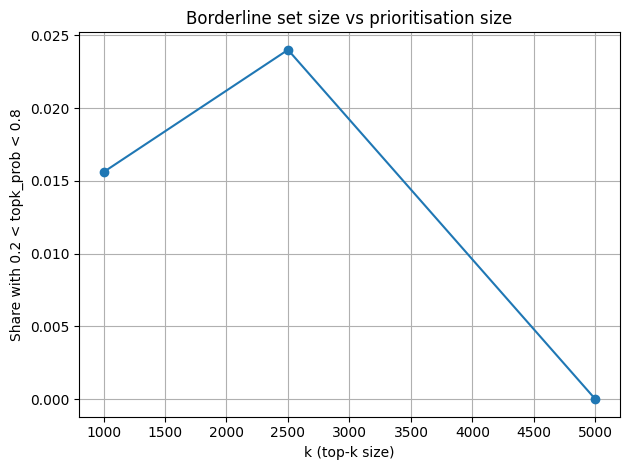

Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\figures\borderline_share_vs_k.png


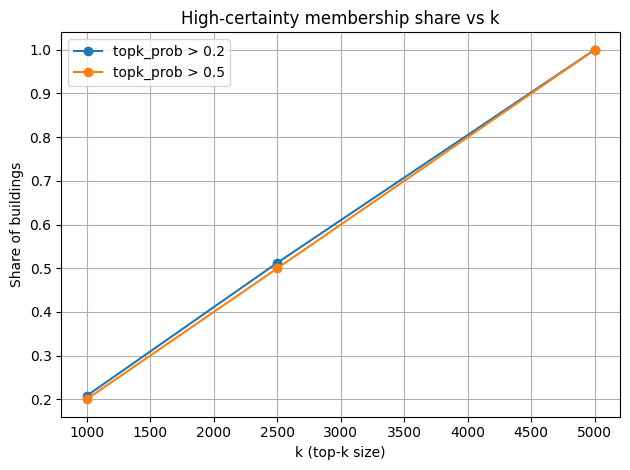

Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\figures\threshold_shares_vs_k.png


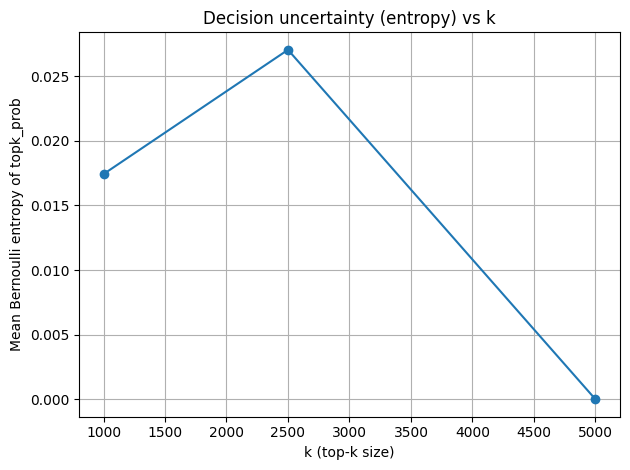

Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\figures\entropy_mean_vs_k.png


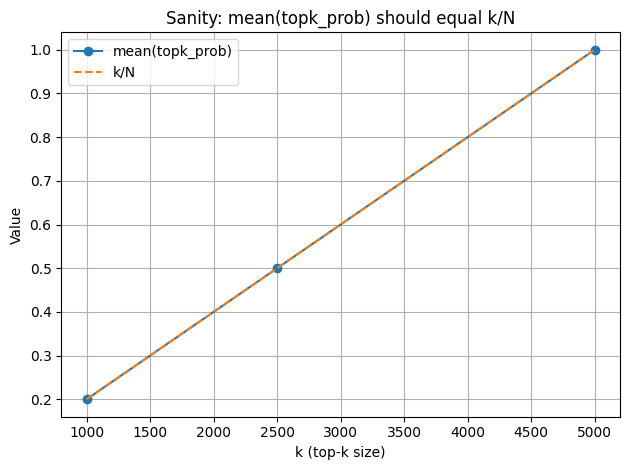

Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\figures\sanity_mean_topkprob_vs_k_over_N.png


In [11]:
# 1) borderline share
plt.figure()
plt.plot(summary["k"], summary["share_borderline_0_2_0_8"], marker="o")
plt.xlabel("k (top-k size)")
plt.ylabel("Share with 0.2 < topk_prob < 0.8")
plt.title("Borderline set size vs prioritisation size")
plt.grid(True)
plt.tight_layout()
p1 = FIG_DIR / "borderline_share_vs_k.png"
plt.savefig(p1, dpi=200)
plt.show()
print("Saved:", p1)

# 2) threshold shares
plt.figure()
for tau in tau_list:
    col = f"share_topkprob_gt_{str(tau).replace('.','_')}"
    plt.plot(summary["k"], summary[col], marker="o", label=f"topk_prob > {tau}")
plt.xlabel("k (top-k size)")
plt.ylabel("Share of buildings")
plt.title("High-certainty membership share vs k")
plt.grid(True)
plt.legend()
plt.tight_layout()
p2 = FIG_DIR / "threshold_shares_vs_k.png"
plt.savefig(p2, dpi=200)
plt.show()
print("Saved:", p2)

# 3) entropy mean
plt.figure()
plt.plot(summary["k"], summary["entropy_mean"], marker="o")
plt.xlabel("k (top-k size)")
plt.ylabel("Mean Bernoulli entropy of topk_prob")
plt.title("Decision uncertainty (entropy) vs k")
plt.grid(True)
plt.tight_layout()
p3 = FIG_DIR / "entropy_mean_vs_k.png"
plt.savefig(p3, dpi=200)
plt.show()
print("Saved:", p3)

# 4) sanity: mean(topk_prob) ~ k/N
plt.figure()
plt.plot(summary["k"], summary["mean_topk_prob"], marker="o", label="mean(topk_prob)")
plt.plot(summary["k"], summary["k_over_N"], linestyle="--", label="k/N")
plt.xlabel("k (top-k size)")
plt.ylabel("Value")
plt.title("Sanity: mean(topk_prob) should equal k/N")
plt.grid(True)
plt.legend()
plt.tight_layout()
p4 = FIG_DIR / "sanity_mean_topkprob_vs_k_over_N.png"
plt.savefig(p4, dpi=200)
plt.show()
print("Saved:", p4)

## Optional: QGIS export (full city)

If you have `bldg_id` in `df_k`, you can export a QGIS-friendly table:
- keep only `bldg_id`, `topk_prob`, `p_mean`, `p_sd` (small columns)
- join onto `processed/RTM/derived/buildings_rtm.gpkg` in the **data** repo by `bldg_id`

Recommended styling in QGIS:
- Graduated on `topk_prob`
- Manually set first class to exactly 0, then quantiles for the non-zero tail